In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


**The next cell is just sorting the data out, you can ignore**

In [46]:
# get data
data_path = "C:/Users/Robert Cartwright/Dropbox/MathsyBoyz/ugly_betting/historic_data/chris_scrape.csv"
df = pd.read_csv(data_path)
df.dropna(inplace=True)

# build tidy dataframe
# integer date
date_df = df[['Date']].copy()
date_df['Date'] = pd.to_datetime(date_df['Date'], format="%d/%m/%Y").dt.strftime("%Y%m%d")
date_df.columns = ['date']

# odds
odds_df = df[['SP']].copy()
odds_df['SP'] = odds_df['SP'].str.replace('Evens', '1/1')
odds_df['SP'] = odds_df['SP'].str.replace('Evs', '1/1')
odds_df['SP'] = odds_df['SP'].str.replace('"', '')
odds_df = odds_df['SP'].str.split(pat='/', expand=True)
odds_df.columns = ['ret', 'stake']
odds_df = odds_df.astype(int)
odds_df['imp_prob'] = odds_df['stake'] / (odds_df['ret'] + odds_df['stake'])
odds_df['dec_odds'] = 1.0 / odds_df['imp_prob']

# results
res_df = df[['Resuls']].copy()
res_df = res_df['Resuls'].str.split(pat='/', expand=True)
res_df.columns = ['place', 'runners']
res_df['place'] = res_df['place'].str.replace('F', '0')
res_df['place'] = res_df['place'].str.replace('P', '0')
res_df['place'] = res_df['place'].str.replace('U', '0')
res_df['place'] = res_df['place'].str.replace('RR', '0')
res_df['place'] = res_df['place'].str.replace('B', '0')
res_df['place'] = res_df['place'].str.replace('R', '0')
res_df['place'] = res_df['place'].str.replace('O', '0')
res_df['place'] = res_df['place'].str.replace('S', '0')
res_df['place'] = res_df['place'].str.replace('D', '')
res_df = res_df.astype(int)

# rebuild
data_df = df[['Nap', 'Tipster', 'Race Track', 'Owner', 'Trainer', 'Jockey', 'Race Type']].copy()
data_df.columns = ['nap', 'tipster', 'race_track', 'owner', 'trainer', 'jockey', 'race_type']
analysis_df = pd.concat([date_df, odds_df, res_df, data_df], axis=1)

# add betsize and pnl column (assuming we want to win £1 from a bet)
analysis_df['betsize'] = 1
analysis_df['pnl'] = np.where(
    analysis_df['place'] == 1,
    1,
    -(1.0/((analysis_df['dec_odds'] - 1.0)))
)
analysis_df['imp_prob_quint'] = pd.qcut(analysis_df['imp_prob'], 5, labels=False) + 1
analysis_df.sort_values('date', ascending=True, inplace=True)
print(analysis_df.tail(5))

           date  ret  stake  imp_prob  dec_odds  place  runners  \
4343   20180512    8      1  0.111111       9.0     15       27   
1307   20180512   25      1  0.038462      26.0      7       27   
15861  20180512    8      1  0.111111       9.0     10       13   
12744  20180512    9      1  0.100000      10.0      4       27   
2094   20180512   12      1  0.076923      13.0      7       16   

                  nap                            tipster race_track  \
4343    Silent Attack          Garry Owen (Daily Record)      Ascot   
1307        Gilgamesh     Alex Hammond (Sky Sports News)      Ascot   
15861      Be Perfect            The North (Racing Post)     Thirsk   
12744         Sabador      Robin Goodfellow (Daily Mail)      Ascot   
2094   John Constable  Chris Goulding (Scottish Express)    Haydock   

                               owner     trainer        jockey race_type  \
4343                       Godolphin  S De Sousa  S bin Suroor      Flat   
1307              

With implied probability I have used quintiles as they're not evenly distributed (i.e given them a ranking between 1 & 5)

**The next section gives tipster performance using all tips**

In [47]:
# tipster performance
tip_perf_df = pd.DataFrame()
for tipster in analysis_df['tipster'].unique():
    tipster_df = analysis_df[analysis_df['tipster'] == tipster]
    tip_perf_df.loc[tipster, 'total_pnl'] = tipster_df['pnl'].sum()
tip_perf_df.sort_values('total_pnl', ascending=False, inplace=True)
print(tip_perf_df)

                                          total_pnl
Robin Goodfellow (Daily Mail)             17.186586
Fortunatus (Sheffield Star)               16.322908
Charlie Croasdale (Chester Leader)        12.653446
The Duke (Yorkshire Post)                 11.751044
Jim Delahunt (Scottish Sun)                5.932026
RP Ratings (Racing Post)                   4.992978
Newmarket (Racing Post)                    4.156818
PicksfromthePaddock (Glasgow Herald)       3.529227
- (The Guardian)                           2.925097
Phil Rostron (Carlisle News & Star)        2.117612
Alex Hammond (Sky Sports News)             0.487986
Rory Delargy (The Irish Field)            -0.544063
Templegate (The Sun)                      -0.614766
Ben Linfoot (sportinglife.com)            -0.879863
Spotlight (Racing Post)                   -1.375891
Rob Wright (The Times)                    -3.272565
The North (Racing Post)                   -4.117963
Gary Nutting (Sunday Mirror)              -4.726612
Paul Kealy (

**This cell gives tip performance by implied probability quintile**

    total_pnl
4  -33.359685
1  -50.081690
2  -72.977700
3 -188.595996
5 -442.206566


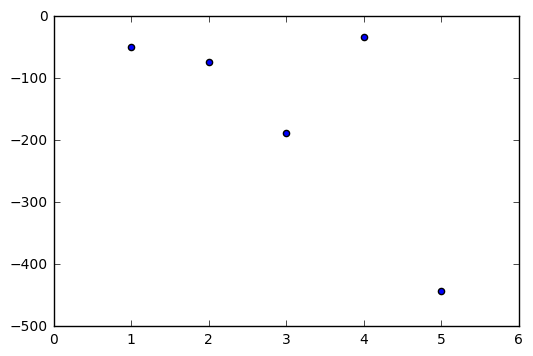

In [48]:
# imnplied prob performance
quint_perf_df = pd.DataFrame()
for quintile in analysis_df['imp_prob_quint'].unique():
    quintile_df = analysis_df[analysis_df['imp_prob_quint'] == quintile]
    quint_perf_df.loc[quintile, 'total_pnl'] = quintile_df['pnl'].sum()
quint_perf_df.sort_values('total_pnl', ascending=False, inplace=True)
print(quint_perf_df)
scatter(quint_perf_df.index, quint_perf_df['total_pnl'])

Quintile 5 is really bad. This is the quintile with highest implied odds. Quintile 4 appears to be an outlier

In [41]:
quintile_df = analysis_df[analysis_df['imp_prob_quint'] == 5]
max_prob = quintile_df['imp_prob'].max()
min_prob = quintile_df['imp_prob'].min()
print(min_prob, max_prob)
print(1.0/min_prob, 1.0/max_prob)

(0.42105263157894735, 0.96153846153846156)
(2.375, 1.04)


So it looks like we should avoid any tip with implied probability greater than 42%, or odds less than 2.375. **This may be a good strategy in itself - lay at starting price any tip with odds less than 2.375. This can be done on Betfair.** We'll have to look into betfair starting prices however

**Let's take a look at laying at SP**

First look at difference between multiple back horses:

In [72]:
# group tips by day and horse
tips_num_df = analysis_df.groupby(['date','nap']).size().reset_index(name='nap_count')
odds_group_df = analysis_df.groupby(['date','nap'], as_index=False).mean()
group_df = pd.concat([tips_num_df, odds_group_df], axis=1)
edge_list = []
for i in range(1, 11):
    for j in range(1, 6):
        try:
            count_df = group_df[(group_df['nap_count'] == i) & (group_df['imp_prob_quint'] == j)]
            pnl = count_df['pnl'].sum()
            wins = len(count_df[count_df['place'] == 1])
            total_count = len(count_df)
            implied_wins = count_df['imp_prob'].sum()
            imp_prob = implied_wins / total_count
            real_prob = wins*1.0 / total_count*1.0
            edge_list.append([i, j, imp_prob, real_prob, total_count, pnl])
        except:
            pass
edge_df = pd.DataFrame(edge_list)
edge_df.columns = ['naps', 'imp_prob_quint', 'imp_prob', 'real_prob', 'total_count', 'pnl']
edge_df['edge'] = edge_df['real_prob'] - edge_df['imp_prob']
print(edge_df)


    naps  imp_prob_quint  imp_prob  real_prob  total_count         pnl  \
0      1               1  0.084797   0.075407         3196  -32.934858   
1      1               2  0.159976   0.127431         1954  -75.620047   
2      1               3  0.230912   0.197461         2127  -93.684524   
3      1               4  0.332657   0.305233         1720  -72.030963   
4      1               5  0.555568   0.507692         1235 -214.887374   
5      2               1  0.093138   0.074380          363   -5.021788   
6      2               2  0.161247   0.141210          347   -4.260800   
7      2               3  0.232944   0.205240          458  -11.382576   
8      2               4  0.338450   0.333333          507    7.813233   
9      2               5  0.556622   0.513043          460  -57.435354   
10     3               1  0.097642   0.079365           63   -0.659019   
11     3               2  0.164413   0.227273           66    5.001010   
12     3               3  0.232022   0

There's definitely a load of negative edge out there (using their starting prices). Probs just the bookies being overround though